In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import time

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_8956/3247981796.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [27]:
# Load the processed data
with open('../data/processed_oil_gas_data.pickle', 'rb') as f:
    processed_data = pickle.load(f)

# Extract the data
X_train = processed_data['X_train']
X_val = processed_data['X_val']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_val = processed_data['y_val']
y_test = processed_data['y_test']
feature_names = processed_data['feature_names']

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")



Training data shape: (541998, 744)
Validation data shape: (6389, 744)
Test data shape: (8114, 744)


In [28]:
# Define a function to evaluate models
def evaluate_model(model, X, y, dataset_name=""):
    """Evaluate a model on the given dataset and print metrics."""
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{dataset_name} RMSE: {rmse:.4f}")
    print(f"{dataset_name} MAE: {mae:.4f}")
    print(f"{dataset_name} R²: {r2:.4f}")
    
    return rmse, mae, r2, y_pred



In [29]:
# 1. Train individual models

# XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(n_estimators=10, random_state=42)

start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time

best_xgb = xgb_model

# Random Forest model
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time

best_rf = rf_model

Training XGBoost model...



Training Random Forest model...


In [30]:
# 2. Create ensemble models

# Voting Regressor (simple averaging)
print("\nTraining Voting Regressor ensemble...")
voting_regressor = VotingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('rf', best_rf)
    ]
)

start_time = time.time()
voting_regressor.fit(X_train, y_train)
voting_time = time.time() - start_time

# # Stacking Regressor (meta-learning)
# print("\nTraining Stacking Regressor ensemble...")
# stacking_regressor = StackingRegressor(
#     estimators=[
#         ('xgb', best_xgb),
#         ('rf', best_rf)
#     ],
#     final_estimator=xgb.XGBRegressor(
#         n_estimators=10,
#         learning_rate=0.05,
#         max_depth=3,
#         random_state=42
#     ),
#     cv=5
# )

# start_time = time.time()
# stacking_regressor.fit(X_train, y_train)
# stacking_time = time.time() - start_time


Training Voting Regressor ensemble...


In [31]:
import pickle

with open('../models/best_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

with open('../models/best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('../models/voting_regressor.pkl', 'wb') as f:
    pickle.dump(voting_regressor, f)

# with open('../models/stacking_regressor.pkl', 'wb') as f:
#     pickle.dump(stacking_regressor, f)


In [32]:
# 3. Evaluate all models
print("\n--- Model Evaluation ---")

# Evaluate XGBoost
print("\nXGBoost Model:")
xgb_train_metrics = evaluate_model(best_xgb, X_train, y_train, "Training")
xgb_val_metrics = evaluate_model(best_xgb, X_val, y_val, "Validation")
xgb_test_metrics = evaluate_model(best_xgb, X_test, y_test, "Test")

# Evaluate Random Forest
print("\nRandom Forest Model:")
rf_train_metrics = evaluate_model(best_rf, X_train, y_train, "Training")
rf_val_metrics = evaluate_model(best_rf, X_val, y_val, "Validation")
rf_test_metrics = evaluate_model(best_rf, X_test, y_test, "Test")

# Evaluate Voting Regressor
print("\nVoting Regressor Ensemble:")
voting_train_metrics = evaluate_model(voting_regressor, X_train, y_train, "Training")
voting_val_metrics = evaluate_model(voting_regressor, X_val, y_val, "Validation")
voting_test_metrics = evaluate_model(voting_regressor, X_test, y_test, "Test")

# # Evaluate Stacking Regressor
# print("\nStacking Regressor Ensemble:")
# stacking_train_metrics = evaluate_model(stacking_regressor, X_train, y_train, "Training")
# stacking_val_metrics = evaluate_model(stacking_regressor, X_val, y_val, "Validation")
# stacking_test_metrics = evaluate_model(stacking_regressor, X_test, y_test, "Test")




--- Model Evaluation ---

XGBoost Model:
Training RMSE: 0.7320
Training MAE: 0.4170
Training R²: 0.7094
Validation RMSE: 1.0289
Validation MAE: 0.8661
Validation R²: -0.2079
Test RMSE: 1.0954
Test MAE: 0.9416
Test R²: -0.4228

Random Forest Model:
Training RMSE: 0.4720
Training MAE: 0.1865
Training R²: 0.8792
Validation RMSE: 0.6938
Validation MAE: 0.4827
Validation R²: 0.4508
Test RMSE: 0.8525
Test MAE: 0.6122
Test R²: 0.1382

Voting Regressor Ensemble:
Training RMSE: 0.5510
Training MAE: 0.2848
Training R²: 0.8353
Validation RMSE: 0.7571
Validation MAE: 0.6078
Validation R²: 0.3460
Test RMSE: 0.8722
Test MAE: 0.7162
Test R²: 0.0979


In [33]:
# Compare model performance
# Remove 'Stacking Ensemble' since it's commented out in the code
models = ['XGBoost', 'Random Forest', 'Voting Ensemble']
train_rmse = [xgb_train_metrics[0], rf_train_metrics[0], voting_train_metrics[0]]
val_rmse = [xgb_val_metrics[0], rf_val_metrics[0], voting_val_metrics[0]]
test_rmse = [xgb_test_metrics[0], rf_test_metrics[0], voting_test_metrics[0]]
training_times = [xgb_time, rf_time, voting_time]

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse,
    'Test RMSE': test_rmse,
    'Training Time (s)': training_times
})

print("\nModel Comparison:")
print(comparison_df.sort_values('Test RMSE'))


Model Comparison:
             Model  Train RMSE  Validation RMSE  Test RMSE  Training Time (s)
1    Random Forest    0.472003         0.693775   0.852521          39.470775
2  Voting Ensemble    0.551024         0.757056   0.872244         146.426014
0          XGBoost    0.732045         1.028879   1.095432          37.358351


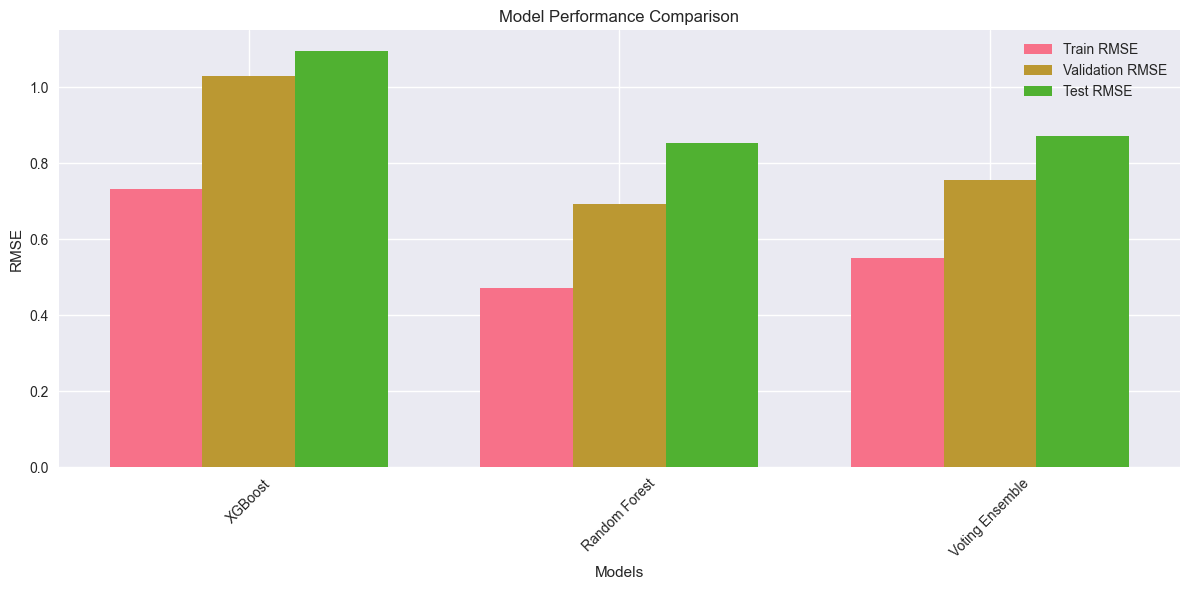

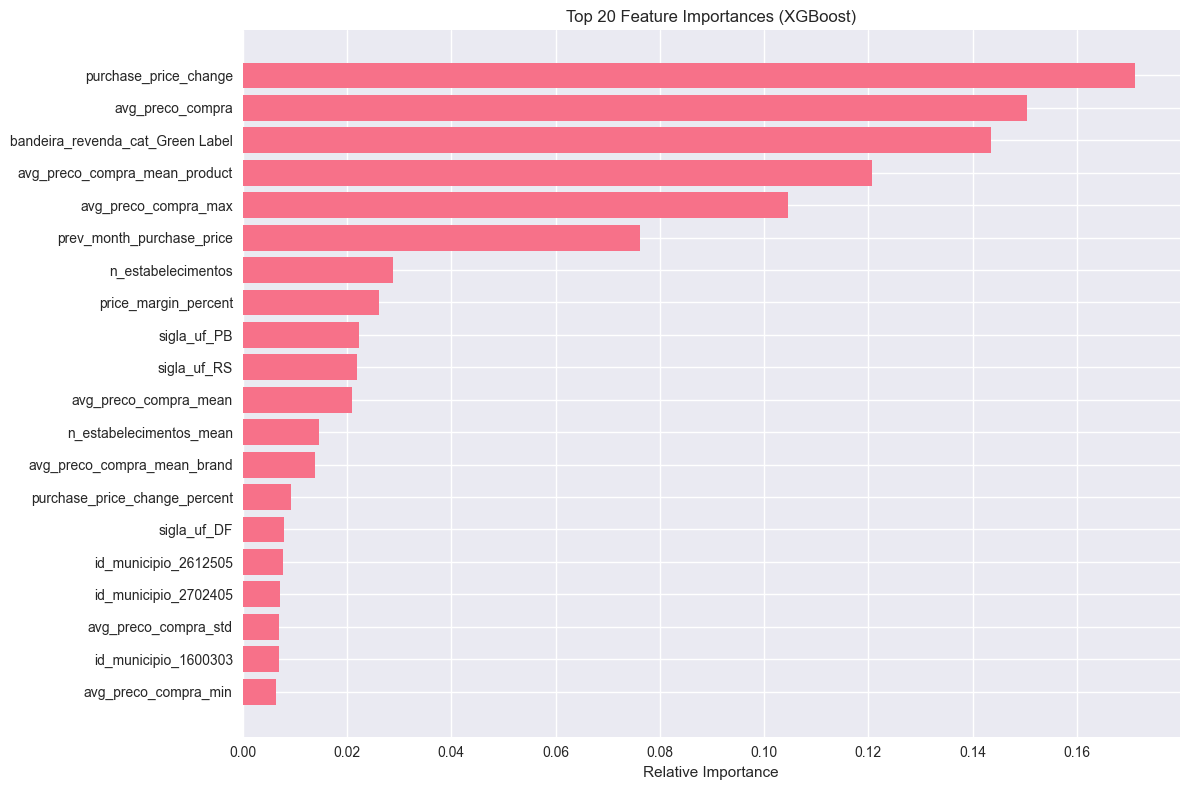

In [34]:
# 5. Visualize model performance
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, train_rmse, width, label='Train RMSE')
plt.bar(x, val_rmse, width, label='Validation RMSE')
plt.bar(x + width, test_rmse, width, label='Test RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Feature importance analysis from the best model
if hasattr(best_xgb, 'feature_importances_'):
    # Get feature importances
    importances = best_xgb.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Feature Importances (XGBoost)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f'Feature {i}' for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()


In [35]:
# Save the best model
# Find the model with the lowest test RMSE from the comparison dataframe
best_model_name = comparison_df.sort_values('Test RMSE').iloc[0]['Model']

if best_model_name == 'XGBoost':
    best_model = best_xgb
elif best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'Voting Ensemble':
    best_model = voting_regressor
elif best_model_name == 'Stacking Ensemble':
    # best_model = stacking_regressor
    pass
else:
    # Default to XGBoost if something goes wrong
    best_model = best_xgb
    best_model_name = 'XGBoost'

with open('../models/best_ensemble_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest model saved: {best_model_name}")



Best model saved: Random Forest


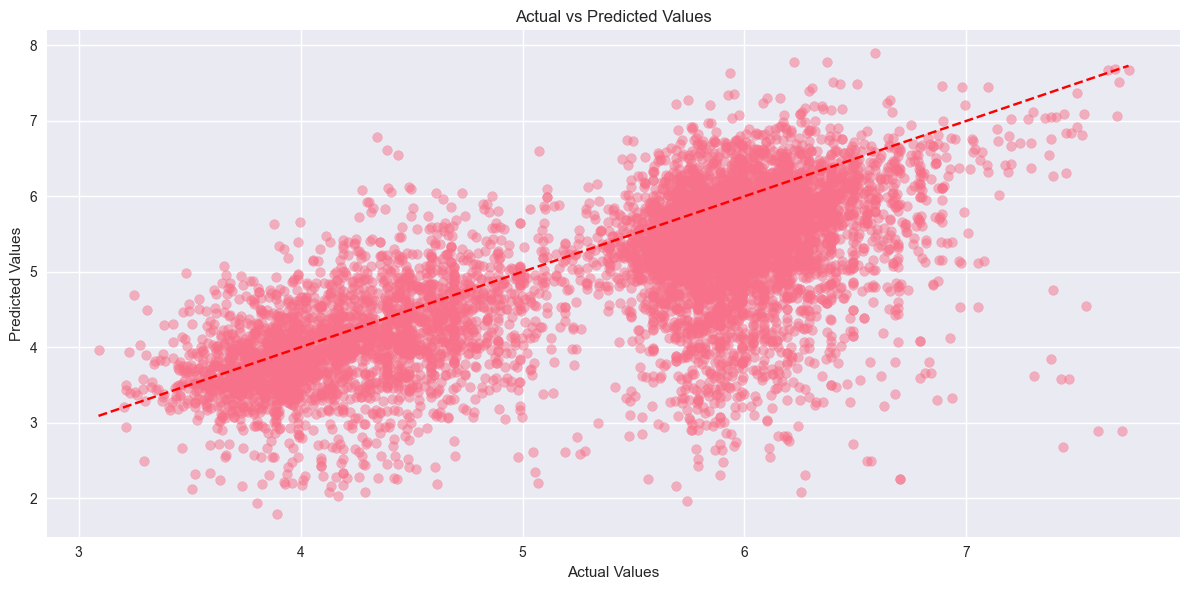

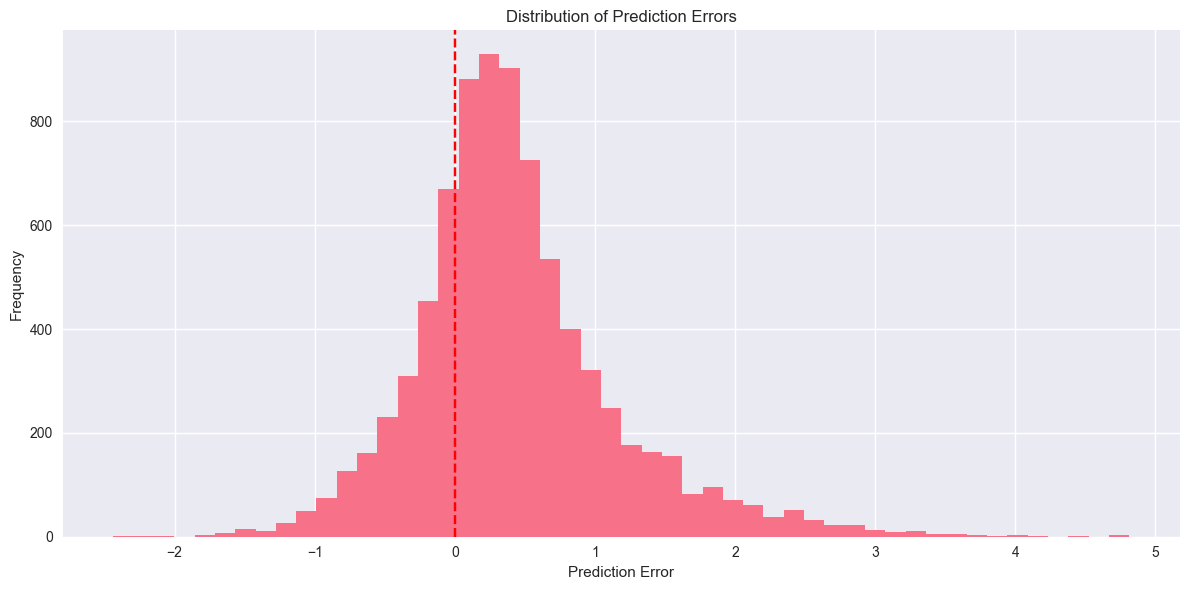

In [36]:
#  Analyze prediction errors
best_preds = best_model.predict(X_test)
errors = y_test - best_preds

plt.figure(figsize=(12, 6))
plt.scatter(y_test, best_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()